# Chronos-2 SFT — Statistical Significance Tests (Global vs Industry-Specific)

This notebook loads the evaluation dumps generated by `chronos2_sft_eval_dump.ipynb` and tests whether performance differences between models are statistically robust.

We treat each **ticker** as one statistical unit (paired setting):
1. Aggregate metrics per ticker (averaged over sampled evaluation windows).
2. Compute paired deltas between models for the same tickers.
3. Run a Wilcoxon signed-rank test and a bootstrap 95% confidence interval for the mean delta.
4. For sector-level results (multiple sectors), apply Benjamini–Hochberg (FDR) correction.

**Sign convention:** Δ = metric(model B) − metric(model A). For MAE/MQL, lower is better, so **negative Δ means model B improves over model A**.


In [1]:
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd

from scipy.stats import wilcoxon

# Repository root (to keep paths consistent across machines)
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)
sys.path.append(project_root)

project_root = Path(os.getcwd()).parent
OUTPUTS_BASE = project_root / "notebooks" / "outputs"
DUMPS_DIR = OUTPUTS_BASE / "eval_dumps" / "sft"
    

# DUMPS_DIR = OUTPUTS_BASE + "\\eval_dumps\\sft"
print("OUTPUTS_BASE:", OUTPUTS_BASE)
print("DUMPS_DIR:", DUMPS_DIR)

# if not DUMPS_DIR.exists():
#     raise FileNotFoundError(f"Dump directory non trovata: {DUMPS_DIR}")

# little check
parquets = sorted(DUMPS_DIR.glob("*.parquet"))
print("n_parquet:", len(parquets))
print("first_files:", [p.name for p in parquets[:10]])

OUTPUTS_BASE: c:\Users\sanit\Desktop\DNLP\Project\chronos_dnlp\notebooks\outputs
DUMPS_DIR: c:\Users\sanit\Desktop\DNLP\Project\chronos_dnlp\notebooks\outputs\eval_dumps\sft
n_parquet: 42
first_files: ['communication_services__baseline.parquet', 'communication_services__sft_category.parquet', 'communication_services__sft_general_ctx_cat.parquet', 'communication_services__sft_general_ctx_global.parquet', 'consumer_discretionary__baseline.parquet', 'consumer_discretionary__sft_category.parquet', 'consumer_discretionary__sft_general_ctx_cat.parquet', 'consumer_discretionary__sft_general_ctx_global.parquet', 'consumer_staples__baseline.parquet', 'consumer_staples__sft_category.parquet']


In [2]:
# Utilities: bootstrap confidence interval and BH/FDR correction
def bootstrap_mean_ci(delta: np.ndarray, n_boot: int = 5000, ci: float = 0.95, seed: int = 123):
    rng = np.random.default_rng(seed)
    n = len(delta)
    if n == 0:
        return (np.nan, np.nan)
    boots = []
    for _ in range(n_boot):
        sample = rng.choice(delta, size=n, replace=True)
        boots.append(sample.mean())
    boots = np.array(boots)
    lo = np.quantile(boots, (1-ci)/2)
    hi = np.quantile(boots, 1-(1-ci)/2)
    return float(lo), float(hi)

def bh_fdr(pvals: np.ndarray):
    pvals = np.asarray(pvals, dtype=float)
    n = len(pvals)
    order = np.argsort(pvals)
    ranked = pvals[order]
    adj = np.empty(n, dtype=float)
    prev = 1.0
    for i in range(n-1, -1, -1):
        rank = i+1
        val = ranked[i] * n / rank
        prev = min(prev, val)
        adj[i] = prev
    out = np.empty(n, dtype=float)
    out[order] = np.clip(adj, 0, 1)
    return out

In [3]:
# Load all parquet dumps
paths = sorted(DUMPS_DIR.glob("*.parquet"))
print("n_parquet:", len(paths))
if len(paths) == 0:
    raise RuntimeError("Nessun parquet trovato in DUMPS_DIR")

dfs = []
for p in paths:
    df = pd.read_parquet(p)
    df["source_file"] = p.name
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print("df_all:", df_all.shape)
df_all.head()

n_parquet: 42
df_all: (72000, 21)


,window_id,start_idx,date,ticker,group,model,context_length,y_true,y_pred_q10,y_pred_q20,...,y_pred_q40,y_pred_q50,y_pred_q60,y_pred_q70,y_pred_q80,y_pred_q90,mae,mse,mql,source_file
0,0,184,2022-05-10 00:00:00+00:00,CMCSA,Communication Services,baseline,128,0.013581,-0.051625,-0.033667,...,-0.020293,-0.016465,-0.013366,-0.010725,-0.008386,-0.006176,0.030046,0.000903,0.013864,communication_services__baseline.parquet
1,0,184,2022-05-10 00:00:00+00:00,CRM,Communication Services,baseline,128,0.021699,-0.085641,-0.055584,...,-0.034463,-0.028185,-0.023013,-0.018546,-0.014516,-0.010660,0.049885,0.002488,0.022887,communication_services__baseline.parquet
2,0,184,2022-05-10 00:00:00+00:00,GOOGL,Communication Services,baseline,128,0.016745,-0.065451,-0.043664,...,-0.027775,-0.022832,-0.018718,-0.015140,-0.011928,-0.008861,0.039577,0.001566,0.018080,communication_services__baseline.parquet
3,0,184,2022-05-10 00:00:00+00:00,T,Communication Services,baseline,128,-0.009719,-0.056527,-0.031768,...,-0.016174,-0.012397,-0.009495,-0.007089,-0.005084,-0.003258,0.002678,0.000007,0.002119,communication_services__baseline.parquet
4,0,184,2022-05-10 00:00:00+00:00,TMUS,Communication Services,baseline,128,0.010433,-0.063390,-0.040039,...,-0.022706,-0.017846,-0.013924,-0.010556,-0.007595,-0.004807,0.028278,0.000800,0.012693,communication_services__baseline.parquet


In [4]:
# Aggregate to ticker level (statistical unit = ticker): average across windows
metrics = ["mae", "mql"]
agg = (df_all
       .groupby(["group", "model", "ticker"], as_index=False)[metrics]
       .mean()
      )

print("agg:", agg.shape)
agg.head()

agg: (549, 5)


,group,model,ticker,mae,mql
0,Communication Services,baseline,CMCSA,0.014223,0.006565
1,Communication Services,baseline,CRM,0.022210,0.009980
2,Communication Services,baseline,GOOGL,0.018694,0.008304
3,Communication Services,baseline,T,0.012219,0.005621
4,Communication Services,baseline,TMUS,0.012580,0.005571


In [5]:
# Paired comparison for a single (group, model A, model B)
def paired_test_group(agg_df: pd.DataFrame, group: str, model_a: str, model_b: str, metric: str):
    a = agg_df[(agg_df["group"]==group) & (agg_df["model"]==model_a)][["ticker", metric]].rename(columns={metric:"a"})
    b = agg_df[(agg_df["group"]==group) & (agg_df["model"]==model_b)][["ticker", metric]].rename(columns={metric:"b"})
    m = a.merge(b, on="ticker", how="inner")
    if m.empty:
        return None

    delta = (m["b"] - m["a"]).to_numpy()  # Negative values indicate that model_b improves over model_a (lower is better for MAE/MQL).
    # Wilcoxon may fail in degenerate cases (e.g., all deltas are zero).
    try:
        stat = wilcoxon(delta)
        p = float(stat.pvalue)
    except Exception:
        p = np.nan

    lo, hi = bootstrap_mean_ci(delta, n_boot=5000, ci=0.95, seed=123)
    return {
        "group": group,
        "metric": metric,
        "model_a": model_a,
        "model_b": model_b,
        "n_tickers": int(len(delta)),
        "mean_delta_b_minus_a": float(delta.mean()),
        "median_delta_b_minus_a": float(np.median(delta)),
        "ci95_lo": lo,
        "ci95_hi": hi,
        "p_wilcoxon": p,
    }


In [6]:
# Comparisons of interest
# GLOBAL: baseline vs sft_general
comparisons = []
for metric in metrics:
    res = paired_test_group(agg, "global", "baseline", "sft_general", metric)
    if res: comparisons.append(res)

# SECTORS:
# - baseline vs sft_category
# - sft_general vs sft_category (using the FAIR dumps with sector-specific context length)
# Note: sector-level dumps include multiple files for the same logical model name.
# We select the FAIR variant for SFT-General: '__sft_general_ctx_cat.parquet'.
# We also include '__baseline.parquet' and '__sft_category.parquet' for the same sector.

# Build a FAIR aggregation for sectors
cat_mask_general_fair = df_all["source_file"].str.contains("__sft_general_ctx_cat.parquet")
cat_mask_category = df_all["source_file"].str.contains("__sft_category.parquet")
cat_mask_baseline = df_all["source_file"].str.contains("__baseline.parquet") & (df_all["group"]!="global")

df_cat_fair = df_all[cat_mask_general_fair | cat_mask_category | cat_mask_baseline].copy()

agg_cat_fair = (df_cat_fair
       .groupby(["group", "model", "ticker"], as_index=False)[metrics]
       .mean()
      )

cats = sorted([g for g in agg_cat_fair["group"].unique() if g!="global"])
print("n_categories in dumps:", len(cats))

for cat in cats:
    for metric in metrics:
        r1 = paired_test_group(agg_cat_fair, cat, "baseline", "sft_category", metric)
        if r1: comparisons.append(r1)

        r2 = paired_test_group(agg_cat_fair, cat, "sft_general", "sft_category", metric)
        if r2: comparisons.append(r2)

df_comp = pd.DataFrame(comparisons)
df_comp

n_categories in dumps: 10


,group,metric,model_a,model_b,n_tickers,mean_delta_b_minus_a,median_delta_b_minus_a,ci95_lo,ci95_hi,p_wilcoxon
0,global,mae,baseline,sft_general,114,-0.002379,-0.002145,-0.002570,-0.002196,1.918356e-20
1,global,mql,baseline,sft_general,114,-0.001176,-0.001073,-0.001259,-0.001097,1.918356e-20
2,Communication Services,mae,baseline,sft_category,6,-0.003876,-0.003740,-0.005689,-0.002331,3.125000e-02
3,Communication Services,mae,sft_general,sft_category,6,-0.001784,-0.001676,-0.002588,-0.001056,3.125000e-02
4,Communication Services,mql,baseline,sft_category,6,-0.001746,-0.001741,-0.002495,-0.001082,3.125000e-02
5,Communication Services,mql,sft_general,sft_category,6,-0.000693,-0.000704,-0.001033,-0.000338,6.250000e-02
6,Consumer Discretionary,mae,baseline,sft_category,10,-0.004053,-0.004169,-0.004541,-0.003495,1.953125e-03
7,Consumer Discretionary,mae,sft_general,sft_category,10,-0.001064,-0.001130,-0.001305,-0.000831,1.953125e-03
8,Consumer Discretionary,mql,baseline,sft_category,10,-0.001442,-0.001426,-0.001642,-0.001229,1.953125e-03
9,Consumer Discretionary,mql,sft_general,sft_category,10,0.000066,0.000061,-0.000012,0.000147,2.324219e-01


In [7]:
# BH/FDR correction for multiple comparisons (sectors only; applied separately for each metric and model comparison)
df_comp["p_adj_bh"] = np.nan

for (metric, model_a, model_b), sub in df_comp[df_comp["group"]!="global"].groupby(["metric","model_a","model_b"]):
    p = sub["p_wilcoxon"].to_numpy()
    adj = bh_fdr(p)
    df_comp.loc[sub.index, "p_adj_bh"] = adj

# Sort by statistical significance
df_comp_sorted = df_comp.sort_values(["metric","model_a","model_b","p_adj_bh","p_wilcoxon"])
df_comp_sorted.head(20)

,group,metric,model_a,model_b,n_tickers,mean_delta_b_minus_a,median_delta_b_minus_a,ci95_lo,ci95_hi,p_wilcoxon,p_adj_bh
22,Health Care,mae,baseline,sft_category,18,-0.003338,-0.003253,-0.003878,-0.002807,7.629395e-06,0.000038
26,Industrials,mae,baseline,sft_category,18,-0.002755,-0.002792,-0.003143,-0.002351,7.629395e-06,0.000038
18,Financials,mae,baseline,sft_category,17,-0.001905,-0.001934,-0.002192,-0.001615,1.525879e-05,0.000038
30,Information Technology,mae,baseline,sft_category,17,-0.004232,-0.004168,-0.004801,-0.003660,1.525879e-05,0.000038
10,Consumer Staples,mae,baseline,sft_category,11,-0.001816,-0.001615,-0.002214,-0.001471,9.765625e-04,0.001953
6,Consumer Discretionary,mae,baseline,sft_category,10,-0.004053,-0.004169,-0.004541,-0.003495,1.953125e-03,0.003255
2,Communication Services,mae,baseline,sft_category,6,-0.003876,-0.003740,-0.005689,-0.002331,3.125000e-02,0.039062
14,Energy,mae,baseline,sft_category,6,-0.004209,-0.003910,-0.005125,-0.003449,3.125000e-02,0.039062
34,Materials,mae,baseline,sft_category,2,-0.003422,-0.003422,-0.003563,-0.003281,5.000000e-01,0.500000
38,Real Estate,mae,baseline,sft_category,2,-0.003475,-0.003475,-0.003963,-0.002987,5.000000e-01,0.500000


In [8]:
# Save results
OUT_DIR = OUTPUTS_BASE / "stats_results" / "sft"
OUT_DIR.mkdir(parents=True, exist_ok=True)

out_csv = OUT_DIR / "paired_tests_ticker_level.csv"
df_comp_sorted.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# Quick view: global results + top sectors (by MQL) for baseline vs sector-specific SFT
display(df_comp_sorted[df_comp_sorted["group"]=="global"])
display(df_comp_sorted[(df_comp_sorted["metric"]=="mql") & (df_comp_sorted["model_a"]=="baseline") & (df_comp_sorted["model_b"]=="sft_category")].head(15))

Saved: c:\Users\sanit\Desktop\DNLP\Project\chronos_dnlp\notebooks\outputs\stats_results\sft\paired_tests_ticker_level.csv


,group,metric,model_a,model_b,n_tickers,mean_delta_b_minus_a,median_delta_b_minus_a,ci95_lo,ci95_hi,p_wilcoxon,p_adj_bh
0,global,mae,baseline,sft_general,114,-0.002379,-0.002145,-0.002570,-0.002196,1.918356e-20,NaN
1,global,mql,baseline,sft_general,114,-0.001176,-0.001073,-0.001259,-0.001097,1.918356e-20,NaN


,group,metric,model_a,model_b,n_tickers,mean_delta_b_minus_a,median_delta_b_minus_a,ci95_lo,ci95_hi,p_wilcoxon,p_adj_bh
24,Health Care,mql,baseline,sft_category,18,-0.001682,-0.001614,-0.001950,-0.001415,0.000008,0.000038
28,Industrials,mql,baseline,sft_category,18,-0.001113,-0.001147,-0.001288,-0.000932,0.000008,0.000038
20,Financials,mql,baseline,sft_category,17,-0.000875,-0.000828,-0.000981,-0.000772,0.000015,0.000038
32,Information Technology,mql,baseline,sft_category,17,-0.001292,-0.001250,-0.001532,-0.001066,0.000015,0.000038
12,Consumer Staples,mql,baseline,sft_category,11,-0.000650,-0.000530,-0.000826,-0.000501,0.000977,0.001953
8,Consumer Discretionary,mql,baseline,sft_category,10,-0.001442,-0.001426,-0.001642,-0.001229,0.001953,0.003255
4,Communication Services,mql,baseline,sft_category,6,-0.001746,-0.001741,-0.002495,-0.001082,0.031250,0.039062
16,Energy,mql,baseline,sft_category,6,-0.002141,-0.002083,-0.002574,-0.001750,0.031250,0.039062
36,Materials,mql,baseline,sft_category,2,-0.001199,-0.001199,-0.001365,-0.001034,0.500000,0.500000
40,Real Estate,mql,baseline,sft_category,2,-0.001423,-0.001423,-0.001625,-0.001221,0.500000,0.500000


In [9]:
# Optional: simple plot of the delta distribution for a chosen group
import matplotlib.pyplot as plt

def plot_delta(group: str, model_a: str, model_b: str, metric: str):
    a = agg_cat_fair[(agg_cat_fair["group"]==group) & (agg_cat_fair["model"]==model_a)][["ticker", metric]].rename(columns={metric:"a"})
    b = agg_cat_fair[(agg_cat_fair["group"]==group) & (agg_cat_fair["model"]==model_b)][["ticker", metric]].rename(columns={metric:"b"})
    m = a.merge(b, on="ticker", how="inner")
    delta = (m["b"] - m["a"]).to_numpy()

    plt.figure(figsize=(7,4))
    plt.hist(delta, bins=20)
    plt.axvline(delta.mean(), linestyle="--")
    plt.title(f"Δ {metric}: {model_b} - {model_a} | {group}\n(mean={delta.mean():.4g})")
    plt.xlabel("delta")
    plt.ylabel("count")
    plt.show()

# example
# plot_delta("Information Technology", "sft_general", "sft_category", "mql")

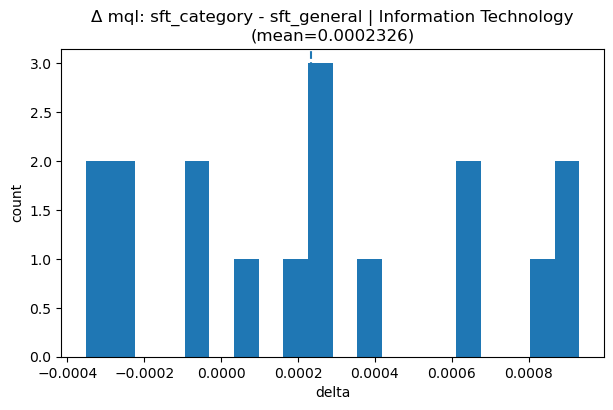

In [10]:
plot_delta("Information Technology", "sft_general", "sft_category", "mql")